# Imports

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import json

In [141]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [142]:
batch_corrected = True
nan_remove = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()
data_col_idx = 19 if batch_corrected else 16

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(nan_remove)+'_'+str(scaler_term)

print(test_enc_name)

_BatchCorTrue_NanRemTrue_minmax


In [143]:
with open(os.path.join('results','significant_lipids_pls2_treatment'+test_enc_name+'.txt'),'r') as f:
    lipid_names = f.read().splitlines()
print(lipid_names)
print(len(lipid_names))

['CE(20:4)+H', 'CER(16:0)+H', 'CER(18:0)+H', 'CER(18:1)+H', 'CER(20:0)+H', 'CER(22:0)+H', 'CER(22:1)+H', 'CER(24:0)+H', 'DAG(16:0_20:3)+NH4', 'DAG(16:0_20:4)+NH4', 'DAG(16:0_22:5)+NH4', 'DAG(16:0_22:6)+NH4', 'DAG(16:1_18:1)+NH4', 'DAG(16:1_20:4)+NH4', 'DAG(18:1_18:1)+NH4', 'DAG(18:1_20:3)+NH4', 'DAG(18:1_22:4)+NH4', 'DAG(18:1_22:6)+NH4', 'DCER(18:0)+H', 'DCER(18:1)+H', 'DCER(20:0)+H', 'DCER(20:1)+H', 'DCER(24:1)+H', 'HCER(18:0)+H', 'HCER(18:1)+H', 'HCER(20:1)+H', 'HCER(22:1)+H', 'HCER(24:1)+H', 'LPC(16:1)+AcO', 'LPC(18:1)+AcO', 'LPC(18:2)+AcO', 'LPC(20:0)+AcO', 'LPC(20:2)+AcO', 'LPC(20:3)+AcO', 'LPC(20:4)+AcO', 'LPC(22:4)+AcO', 'LPC(22:5)+AcO', 'LPC(22:6)+AcO', 'LPE(16:0)-H', 'LPE(18:0)-H', 'LPE(18:2)-H', 'LPE(20:1)-H', 'LPE(20:4)-H', 'LPE(22:4)-H', 'LPE(22:5)-H', 'LPE(22:6)-H', 'LPG(16:0)-H', 'LPI(16:0)-H', 'LPI(18:0)-H', 'LPI(18:1)-H', 'LPI(20:1)-H', 'LPI(20:3)-H', 'LPI(20:4)-H', 'LPS(18:0)-H', 'MAG(16:1)+NH4', 'MAG(18:0)+NH4', 'MAG(18:1)+NH4', 'MAG(18:2)+NH4', 'MAG(20:1)+NH4', 'MAG(

In [144]:
len(lipid_names)

302

In [145]:
sns.set(style = 'whitegrid')

# Load data

In [146]:
data_tmp = pd.read_excel(os.path.join(data_path,'raw_data.xlsx'))
data_tmp.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time\n(min),UNCORRECTED\nPeak Area of Lipid Species,UNCORRECTED\nPeak Area of Internal Standard,UNCORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),BATCH CORRECTED\nPeak Area of Lipid Species,BATCH CORRECTED\nPeak Area of Internal Standard,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,6.142877e+07,0.001197,1.963161e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,6.142877e+07,0.007075,1.490595e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,6.142877e+07,0.041642,8.628739e+07,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,6.142877e+07,0.036870,1.080535e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,6.142877e+07,0.001575,2.723486e+06,4.165659e+07,0.001167


In [118]:
metadata = data_tmp.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, data_tmp.iloc[:,19]],axis=1)
else:
    data = pd.concat([metadata, data_tmp.iloc[:,16]],axis=1)

data_stats = data.reset_index().fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
data_stats.head()

,index,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


In [119]:
data = data_stats.loc[data_stats['Individual Lipid Species'].isin(lipid_names)].copy(deep=True)
data.columns = ['Index','SampleNumber', 'SampleSubmissionDate', 'SampleName', 'Sex', 'TissueWeight', 'Treatment', 'TissueType', 'PND', 'Litter', 'IndividualLipidSpecies', 'LipidClass', 'PeakArea']
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


In [120]:
data['Sex'].value_counts()
data['SampleSubmissionDate'].value_counts()

09/2021    14496
11/2022     7248
Name: SampleSubmissionDate, dtype: int64

In [121]:
data['log_area'] = np.log10(data.iloc[:,-1])
data['log_scaled_area'] = scaler.fit_transform(data[['log_area']])
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea,log_area,log_scaled_area
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842,-3.074916,0.684297
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390,-2.194512,0.760533
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989,-1.431924,0.826567
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320,-1.334233,0.835027
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167,-2.932747,0.696608


# Manipulate data

Add a column to identify the date

In [122]:
def classify_date(input_date):
    if input_date == '09/2021':
        return 1
    else:
        return 2

data['dateId'] = data['SampleSubmissionDate'].apply(lambda x: classify_date(x))

In [123]:
df_sub = data[(data['TissueType'] == 'cortex') & (data['PND'] == 30)].copy()
df_sub['class'] = [0 if x == 'control' else 1 for x in df_sub['Treatment']]

df_pivot = df_sub.pivot_table(index='IndividualLipidSpecies', columns='SampleNumber',values='log_scaled_area',dropna=True).T


class_values = df_sub.groupby('SampleNumber').mean()['class']

print(df_pivot.columns)


Index(['CE(20:4)+H', 'CER(16:0)+H', 'CER(18:0)+H', 'CER(18:1)+H',
       'CER(20:0)+H', 'CER(22:0)+H', 'CER(22:1)+H', 'CER(24:0)+H',
       'DAG(16:0_20:3)+NH4', 'DAG(16:0_20:4)+NH4',
       ...
       'TAG(58:10_FA20:4)+NH4', 'TAG(58:10_FA22:6)+NH4',
       'TAG(58:7_FA22:6)+NH4', 'TAG(58:8_FA22:6)+NH4', 'TAG(58:9_FA20:4)+NH4',
       'TAG(58:9_FA22:6)+NH4', 'TAG(60:10_FA22:6)+NH4',
       'TAG(60:11_FA22:5)+NH4', 'TAG(60:11_FA22:6)+NH4',
       'TAG(60:12_FA22:6)+NH4'],
      dtype='object', name='IndividualLipidSpecies', length=302)


# Figures

In [124]:
data.shape

(21744, 16)

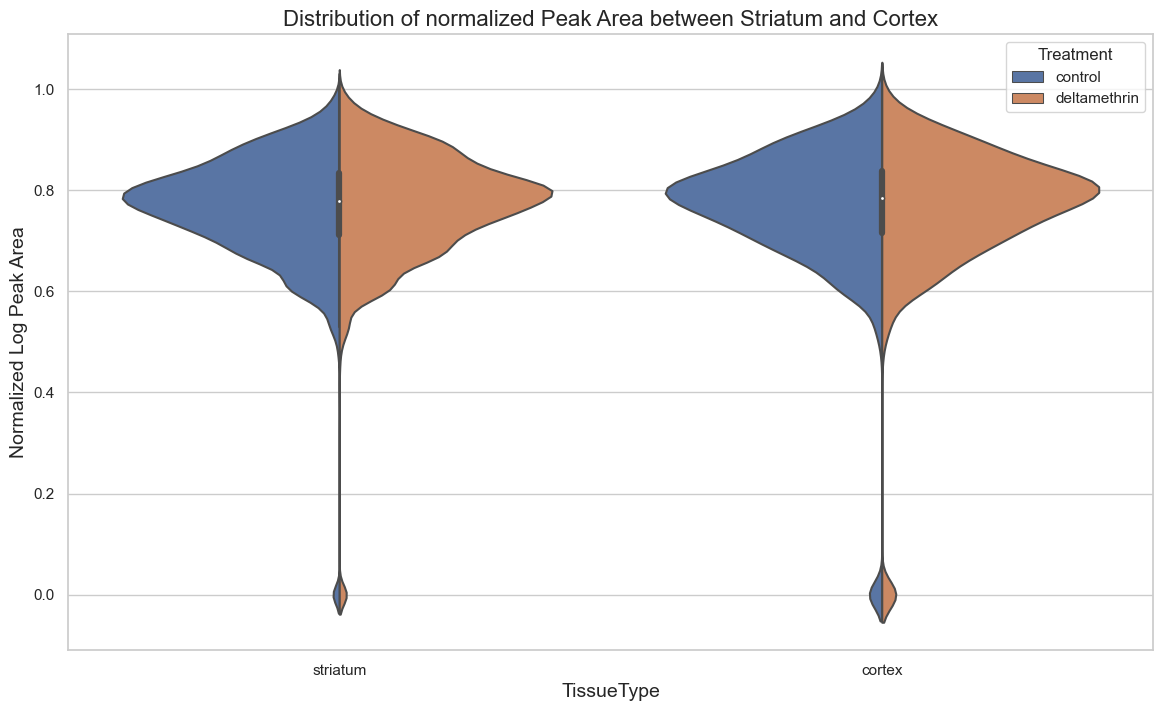

In [127]:
fig = plt.figure(figsize=(14,8), dpi=100)
ax = sns.violinplot(data=data, x='TissueType', hue='Treatment', y='log_scaled_area',split=True, inner='box')

ax.set_title('Distribution of normalized Peak Area between Striatum and Cortex', fontsize=16)
ax.set_xlabel('TissueType', fontsize=14)
ax.set_ylabel('Normalized Log Peak Area', fontsize=14)

fig.savefig(os.path.join(data_path,"violinplot-tissue-no-date.png"), format='png', facecolor='w')

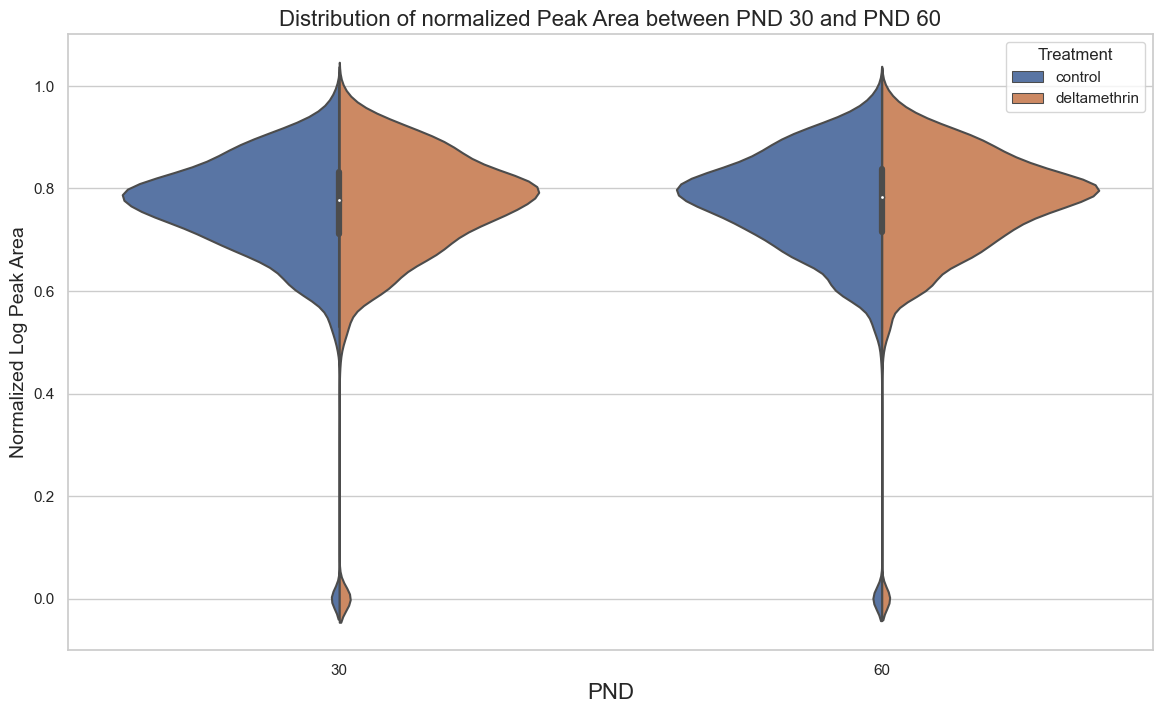

In [128]:
fig = plt.figure(figsize=(14,8), dpi=100)
ax = sns.violinplot(data=data, x='PND', hue='Treatment', y='log_scaled_area',split=True, inner='box')
ax.set_title('Distribution of normalized Peak Area between PND 30 and PND 60', fontsize=16)
ax.set_xlabel('PND', fontsize=16)
ax.set_ylabel('Normalized Log Peak Area', fontsize=14)
                    
fig.savefig(os.path.join(data_path,"violinplot-pnd-no-date.png"), format='png', facecolor='w')

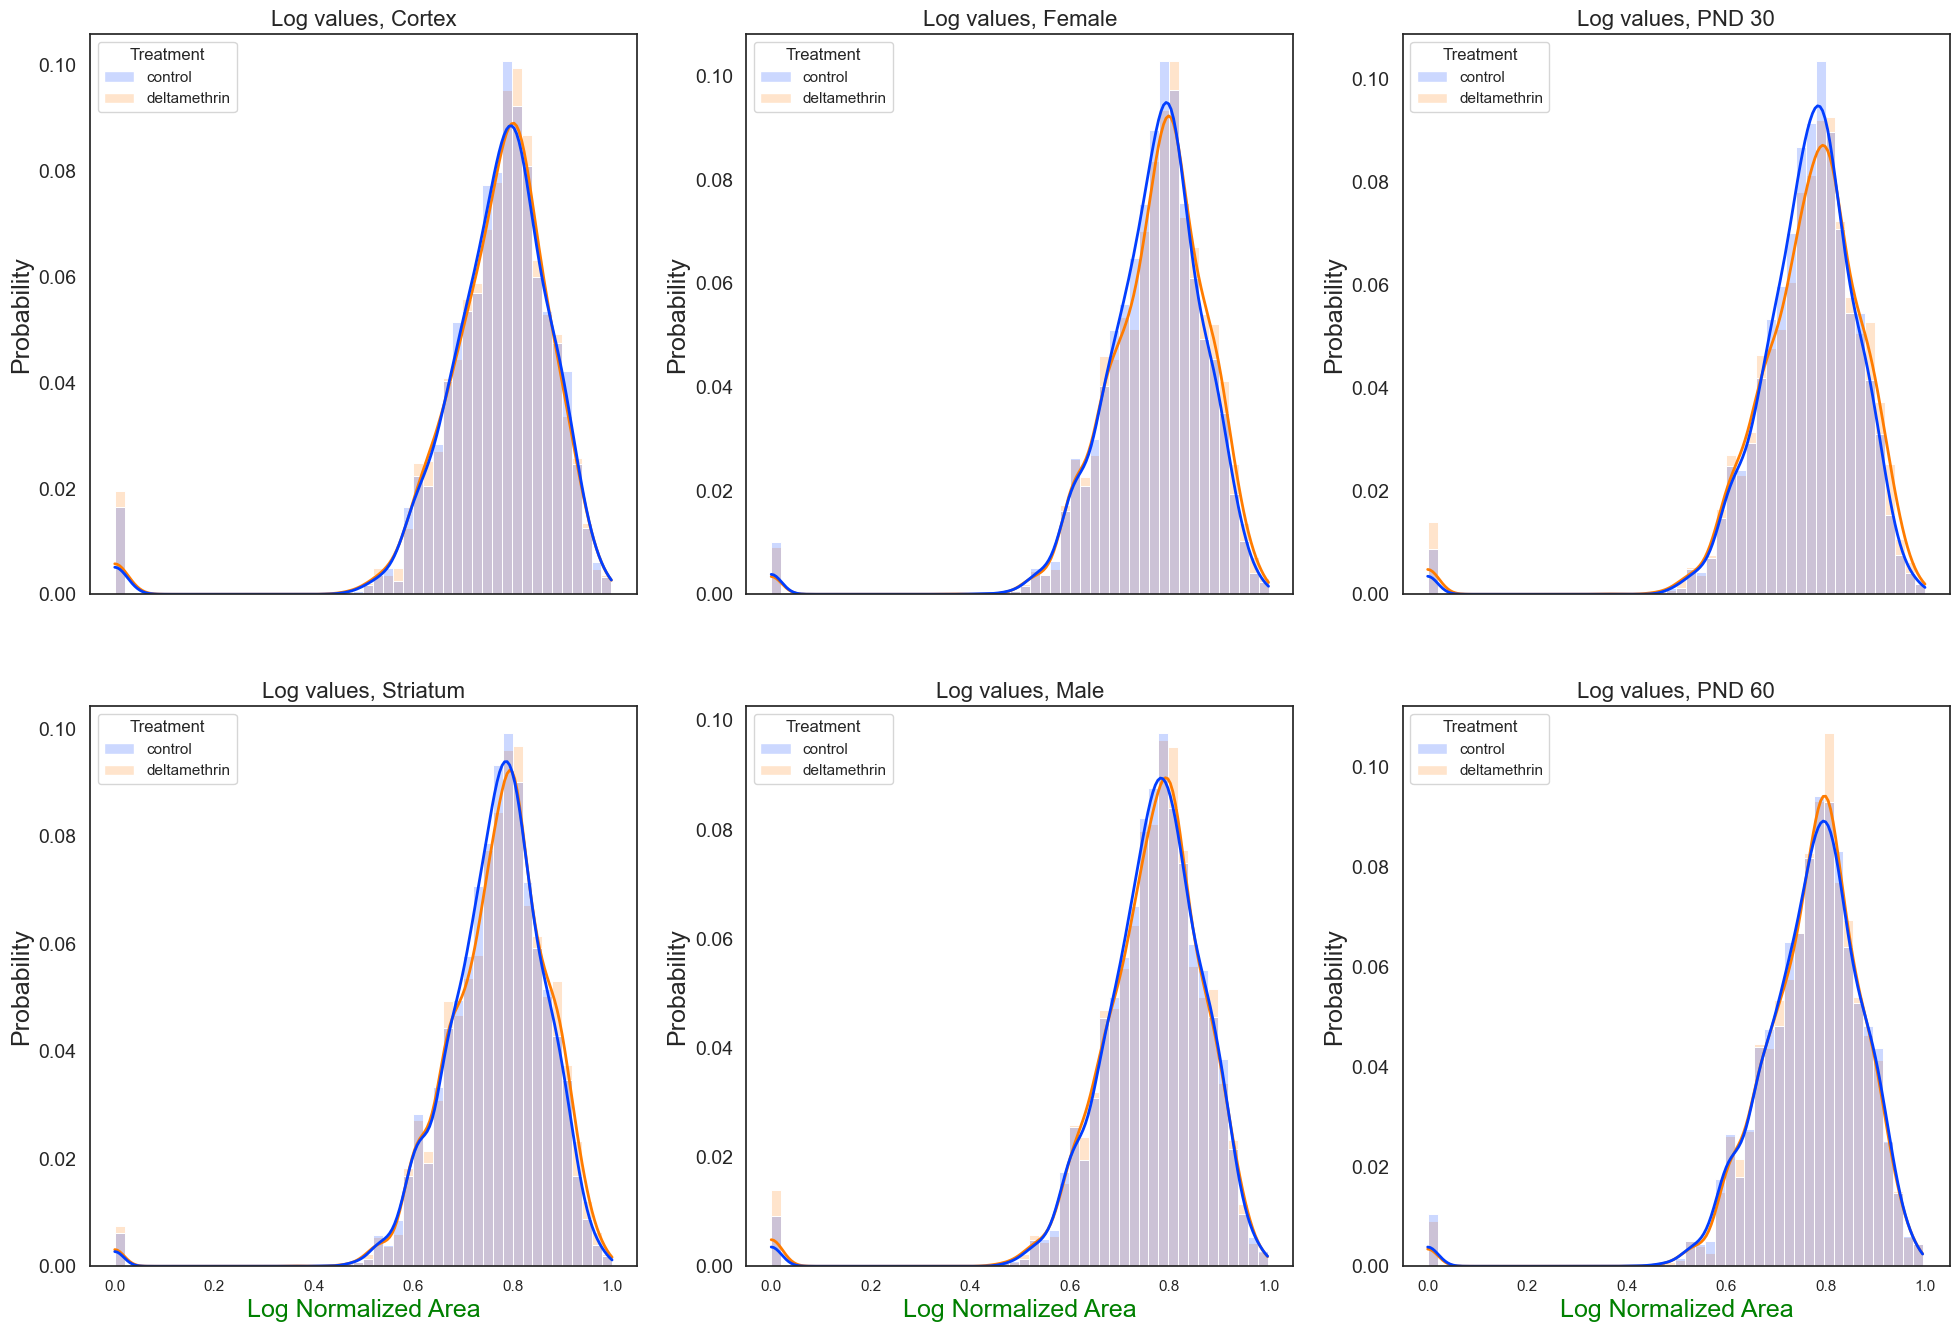

In [129]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,16), )

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['TissueType'] == 'cortex'], x='log_scaled_area', hue='Treatment', ax=ax[0,0], legend=True, **opt)
ax[0,0].set_title('Log values, Cortex', fontsize=16)
ax[0,0].set_ylabel('Probability', fontsize=18)
ax[0,0].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['TissueType'] == 'striatum'], x='log_scaled_area', hue='Treatment', ax=ax[1,0], legend=True, **opt)
ax[1,0].set_title('Log values, Striatum', fontsize=16)
ax[1,0].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,0].set_ylabel('Probability', fontsize=18)
ax[1,0].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['Sex'] == 'F'], x='log_scaled_area', hue='Treatment', ax=ax[0,1], legend=True, **opt)
ax[0,1].set_title('Log values, Female', fontsize=16)
ax[0,1].set_ylabel('Probability', fontsize=18)
ax[0,1].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['Sex'] == 'M'], x='log_scaled_area', hue='Treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male', fontsize=16)
ax[1,1].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,1].set_ylabel('Probability', fontsize=18)
ax[1,1].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['PND'] == 30], x='log_scaled_area', hue='Treatment', ax=ax[0,2], legend=True, **opt)
ax[0,2].set_title('Log values, PND 30', fontsize=16)
ax[0,2].set_ylabel('Probability', fontsize=18)
ax[0,2].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['PND'] == 60], x='log_scaled_area', hue='Treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60', fontsize=16)
ax[1,2].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,2].set_ylabel('Probability', fontsize=18)
ax[1,2].tick_params(axis='y', labelsize=14)

fig.savefig(os.path.join(data_path,"distribution-3cases-no-date.png"), format='png', facecolor='w', dpi=300)

plt.show()

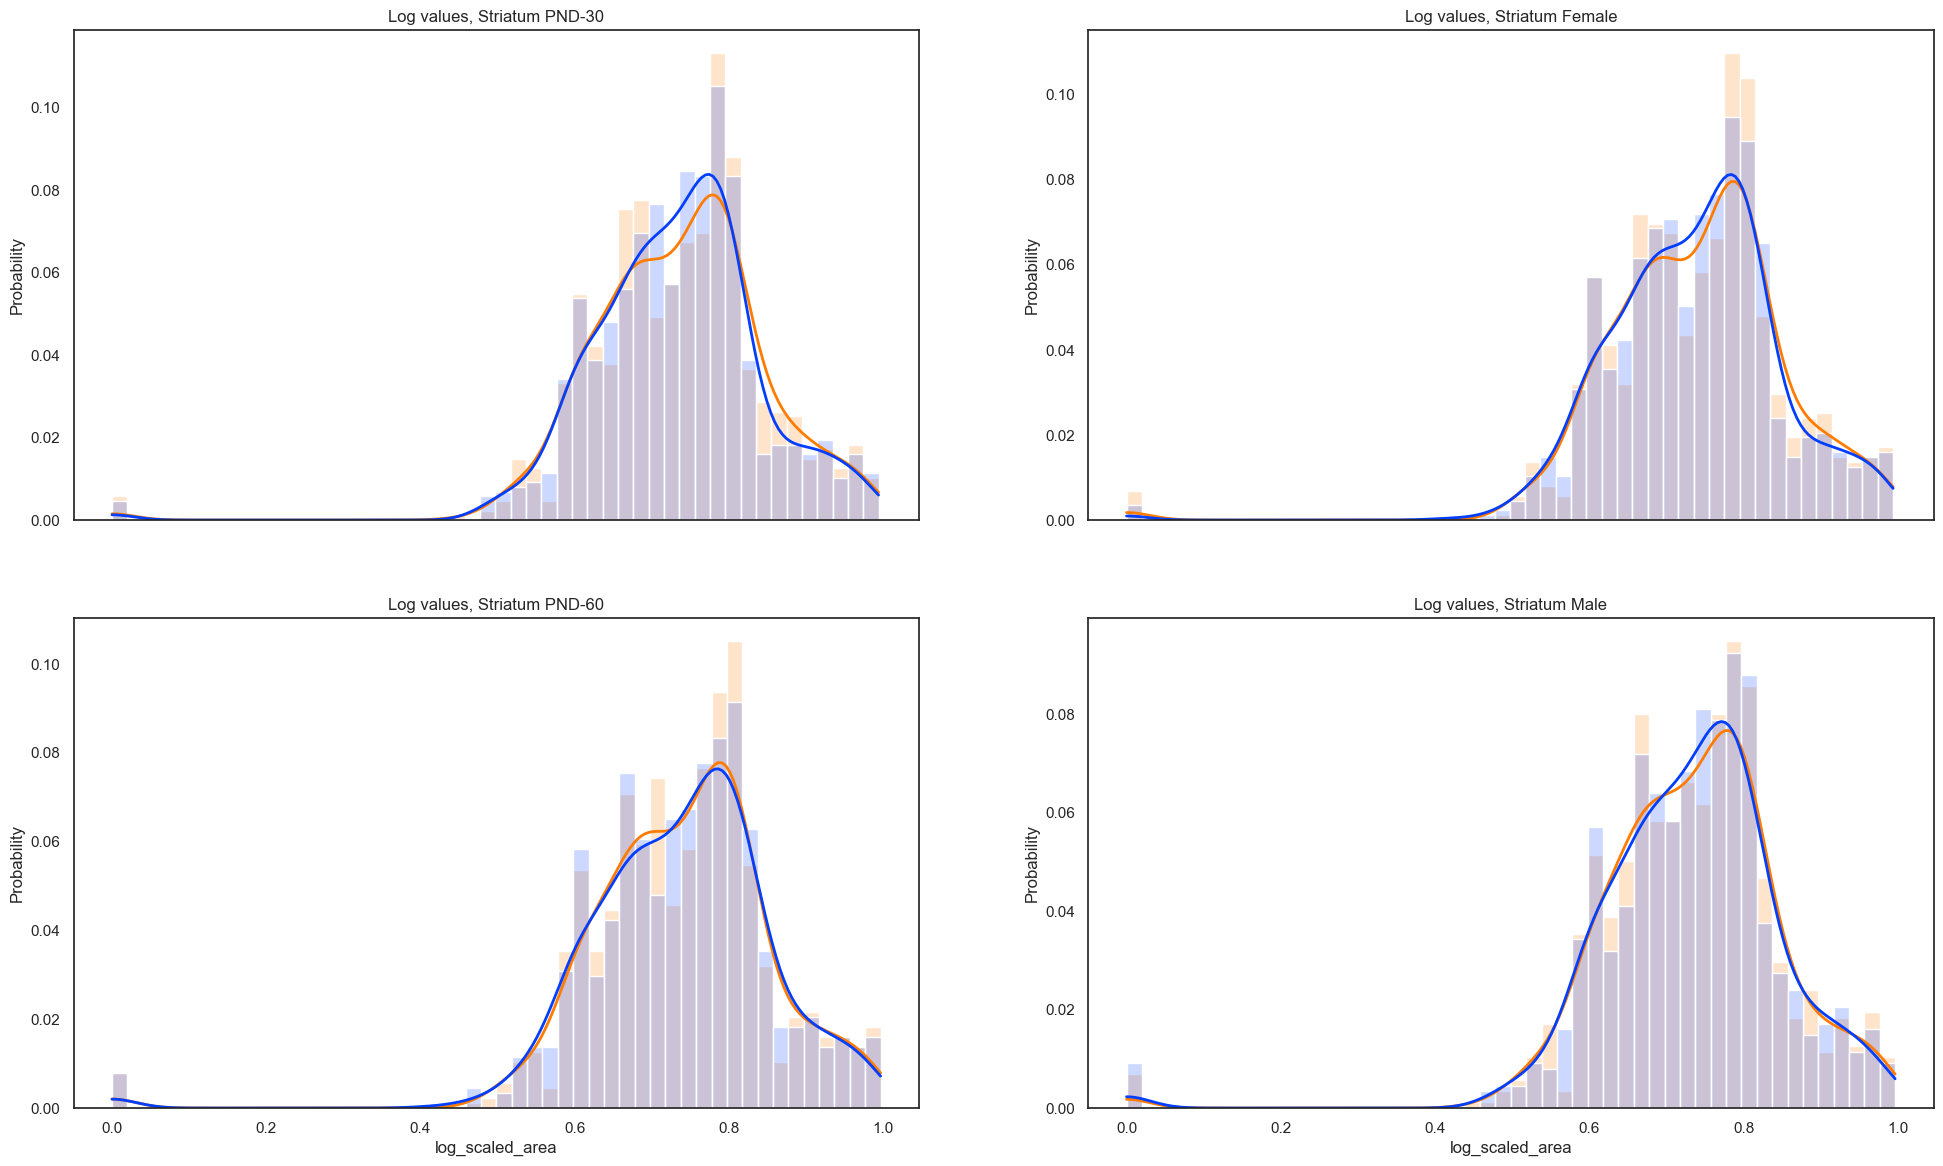

In [18]:
sns.set_style('white')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 30)], x='log_scaled_area', hue='Treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Striatum PND-30')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 60)], x='log_scaled_area', hue='Treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum PND-60')

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'F')], x='log_scaled_area', hue='Treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Striatum Female')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'M')], x='log_scaled_area', hue='Treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Striatum Male')

fig.savefig(os.path.join(data_path,"distribution-Striatum-2cases.svg"), format='svg', facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [19]:
tissue = ['striatum','cortex']
sex = ['F', 'M']
pnd = [30,60]
var_name = 'log_scaled_area'


for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 5.14e-01
Tissue: cortex. P-value: 7.97e-01


#### Data divided by gender

In [20]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: F. P-value: 1.65e-01
Gender: M. P-value: 6.89e-01


#### Data divided by PND

In [21]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 9.50e-01
PND: 60. P-value: 3.19e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [130]:
tissue = ['striatum','cortex']
sex = ['F', 'M']
pnd = [30,60]
var_name = 'log_scaled_area'

for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 6.03e-02
Tissue: cortex. P-value: 3.77e-01


#### Data divided by gender

In [131]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: F. P-value: 3.41e-03
Gender: M. P-value: 9.64e-02


#### Data divided by PND

In [132]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.05e-02
PND: 60. P-value: 4.77e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto il resto. Mentre l'effetto del secondo oridne dice che è vero che partono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi

In [133]:
model = ols('log_scaled_area ~ C(Sex) + C(Treatment) + C(TissueType) + C(dateId) + C(PND) + C(PND):C(Treatment) + C(Sex):C(Treatment) + C(TissueType):C(Treatment) + C(dateId):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.221508,1.0,15.452481,0.000085
C(Treatment),0.009952,1.0,0.694283,0.404720
C(TissueType),0.087964,1.0,6.136375,0.013250
C(dateId),0.056658,1.0,3.952447,0.046816
C(PND),0.178740,1.0,12.468955,0.000415
C(PND):C(Treatment),0.004966,1.0,0.346397,0.556166
C(Sex):C(Treatment),0.149559,1.0,10.433301,0.001239
C(TissueType):C(Treatment),0.021648,1.0,1.510153,0.219129
C(dateId):C(Treatment),0.007064,1.0,0.492815,0.482682
Residual,311.552457,21734.0,NaN,NaN


In [26]:
model = ols('log_scaled_area ~ C(Sex) + C(PND) + C(Treatment) + C(TissueType) + C(PND):C(Treatment) + C(Sex):C(Treatment) + C(TissueType):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.035268,1.0,2.214418,0.136787
C(PND),0.019815,1.0,1.244123,0.264729
C(Treatment),0.005728,1.0,0.359627,0.548739
C(TissueType),0.000459,1.0,0.028833,0.865172
C(PND):C(Treatment),0.027778,1.0,1.744157,0.186671
C(Sex):C(Treatment),0.024025,1.0,1.508477,0.219427
C(TissueType):C(Treatment),0.000051,1.0,0.003217,0.954773
Residual,83.582709,5248.0,NaN,NaN


### Anova only striatum

In [ ]:
data_striatum = data[data['TissueType'] == 'striatum'].copy(deep=True)

In [ ]:
model = ols('log_scaled_area ~ C(Sex) + C(Treatment)  + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.007910,1.0,0.716655,0.397312
C(Treatment),0.000150,1.0,0.013588,0.907209
C(Sex):C(Treatment),0.001171,1.0,0.106090,0.744663
Residual,32.801092,2972.0,NaN,NaN


In [ ]:
model = ols('log_scaled_area ~ C(Sex) + C(PND) + C(Treatment)+ C(PND):C(Treatment) + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.007910,1.0,0.716792,0.397266
C(PND),0.028204,1.0,2.555981,0.109984
C(Treatment),0.000150,1.0,0.013591,0.907201
C(PND):C(Treatment),0.000149,1.0,0.013495,0.907529
C(Sex):C(Treatment),0.001171,1.0,0.106111,0.744639
Residual,32.772739,2970.0,NaN,NaN


# Single lipids statistics

## Define lipids list

In [147]:
lipids_list = data['IndividualLipidSpecies'].unique()
print(lipids_list.shape[0])

302


## Test lipid

In [148]:
data_lipid = data[data['IndividualLipidSpecies'] == lipids_list[0]]

from scipy.stats import ttest_ind
multcomp = mc.MultiComparison(data_lipid['log_scaled_area'], groups=data_lipid['Treatment'])
res = multcomp.allpairtest(ttest_ind)[1][2][0]
print(res)
res = multcomp.allpairtest(ttest_ind)[0]
print(res)

0.03291756208611605
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
 group1    group2     stat   pval  pval_corr reject
---------------------------------------------------
control deltamethrin 2.1762 0.0329    0.0329   True
---------------------------------------------------


## Analysis control vs treatment

In [152]:
lipids_list.shape

(302,)

In [153]:
import itertools
factor = 'Treatment'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([l, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

,lipid,fc,p,Treatment1,Treatment2,effectSize,sampleSize,statisticalPower
0,SM(14:0)+H,1.009251,0.032918,control,deltamethrin,0.520210,36,0.585817
1,SM(16:0)+H,1.005129,0.162395,control,deltamethrin,0.337521,36,0.292354
2,SM(18:0)+H,1.004324,0.367727,control,deltamethrin,0.216720,36,0.148227
3,SM(18:1)+H,1.004092,0.152439,control,deltamethrin,0.345832,36,0.304364
4,SM(20:0)+H,1.005482,0.574527,control,deltamethrin,0.134832,36,0.087196


### Statistical power with average effectSize

In [ ]:
es_mean = np.median(results_all['effectSize'][results_all['p']<0.05])
# es_mean = 0.8
print(es_mean)
n_mice = 24
statisticalPower = TTestIndPower().power(effect_size=es_mean, nobs1=n_mice, alpha=0.05)
print(statisticalPower)

0.5119102514320559
0.4116104853507485


### Given an effect size, and a statistical power, determine n_mice

In [ ]:
es_mean = 0.7
alpha = 0.05
statisticalPower = 0.8
n_mice_ideal = TTestIndPower().solve_power(effect_size=es_mean, alpha=alpha, power=statisticalPower)
print(n_mice_ideal)

33.02456951586259


## Plots

In [42]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break

In [155]:
results_all.shape

(302, 8)

In [169]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5, filename="test.png"):

    class TextHandlerB(HandlerBase):
        def create_artists(self, legend, text ,xdescent, ydescent,
                            width, height, fontsize, trans):
            tx = Text(width/2.,height/2, text, fontsize=fontsize,
                    ha="center", va="center", fontweight="bold")
            return [tx]

    Legend.update_default_handler_map({str : TextHandlerB()})       
    
    #col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))
    col = np.where(-np.log10(results_all['p']) < pvalue_threshold, 'k', 
                            np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k')))

    fig = plt.figure(figsize=(14,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    y_max_value = plt.gca().get_ylim()[1]
    shownlabels = []
    l_ha = ['right','left']
    elem_counter = 1
    legend_data_handles = []
    legend_data_labels = []
    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x, y + 0.03*y_max_value, elem_counter, va='center', color='k', fontsize=14, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.1))
            """ l = plt.text(x+0.01*aa, y,
                         results_all.iloc[i]['lipid'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2)) """
            #shownlabels.append(l)
            legend_circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='r' if x < -fc_threshold else 'g', markersize=10)
            legend_data_handles.append(legend_circle)
            legend_data_labels.append(str(elem_counter) + '-' + results_all.iloc[i]['lipid'])
            #legend_data_keeper.update({str(elem_counter): results_all.iloc[i]['lipid']})
            elem_counter += 1
    #adjustlabels(fig, shownlabels)
    plt.legend(handles=legend_data_handles,labels=legend_data_labels, loc='upper left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 
    fig.savefig(os.path.join(data_path,filename), format='png', facecolor='w', dpi=300)

    plt.show()

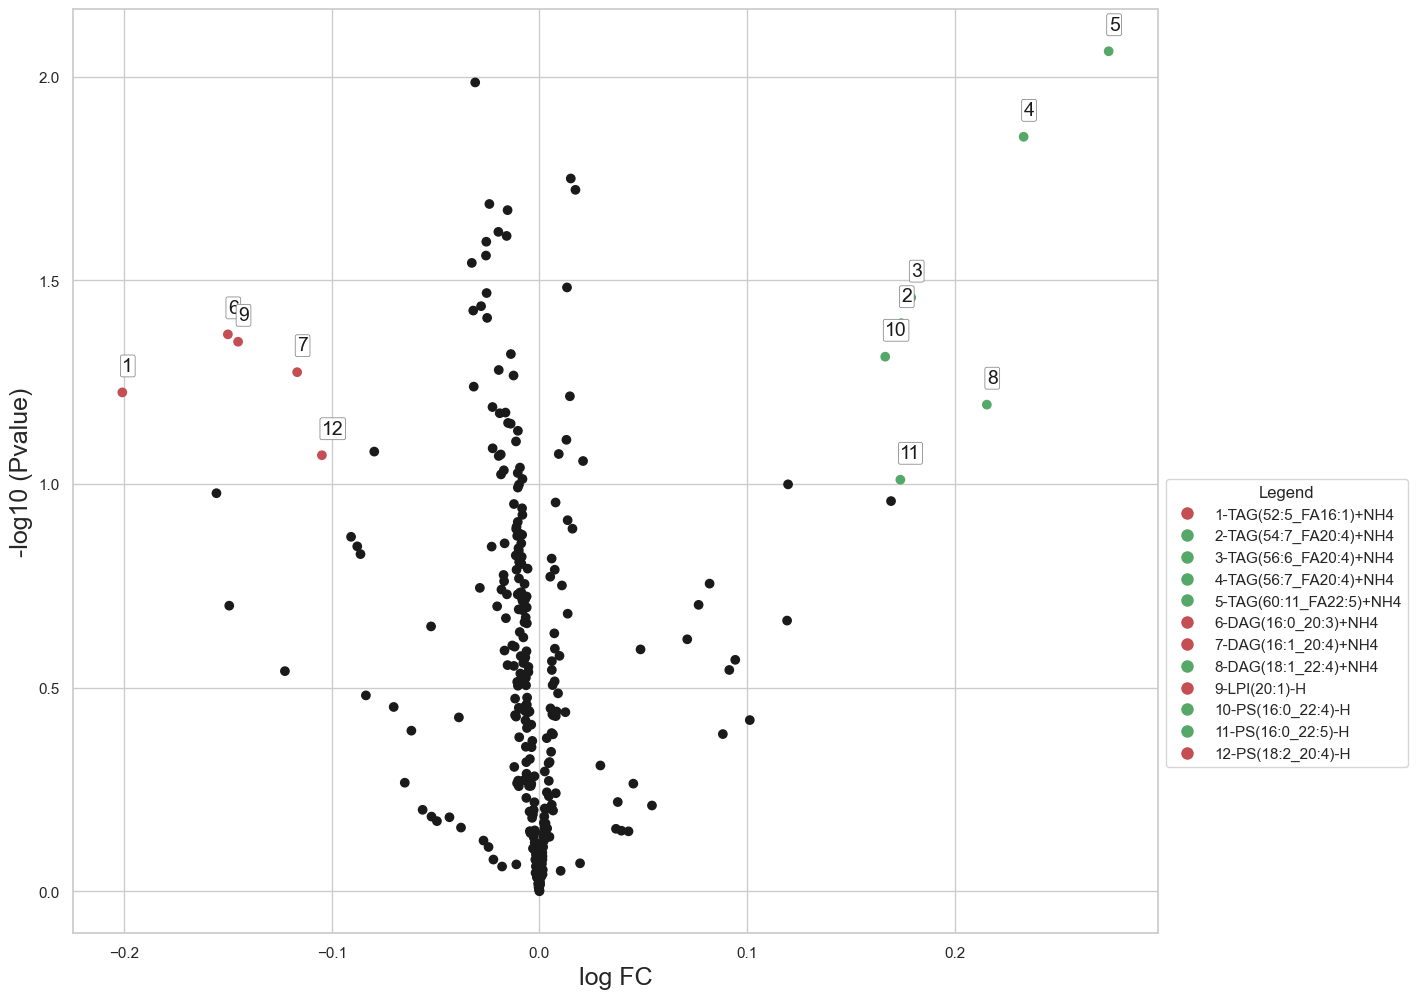

In [170]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-treatment-fc_01_pv_1-no-date.png")

## Analysis striatum vs cortex

In [171]:
factor = 'TissueType'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','tissue_treatment.csv'))

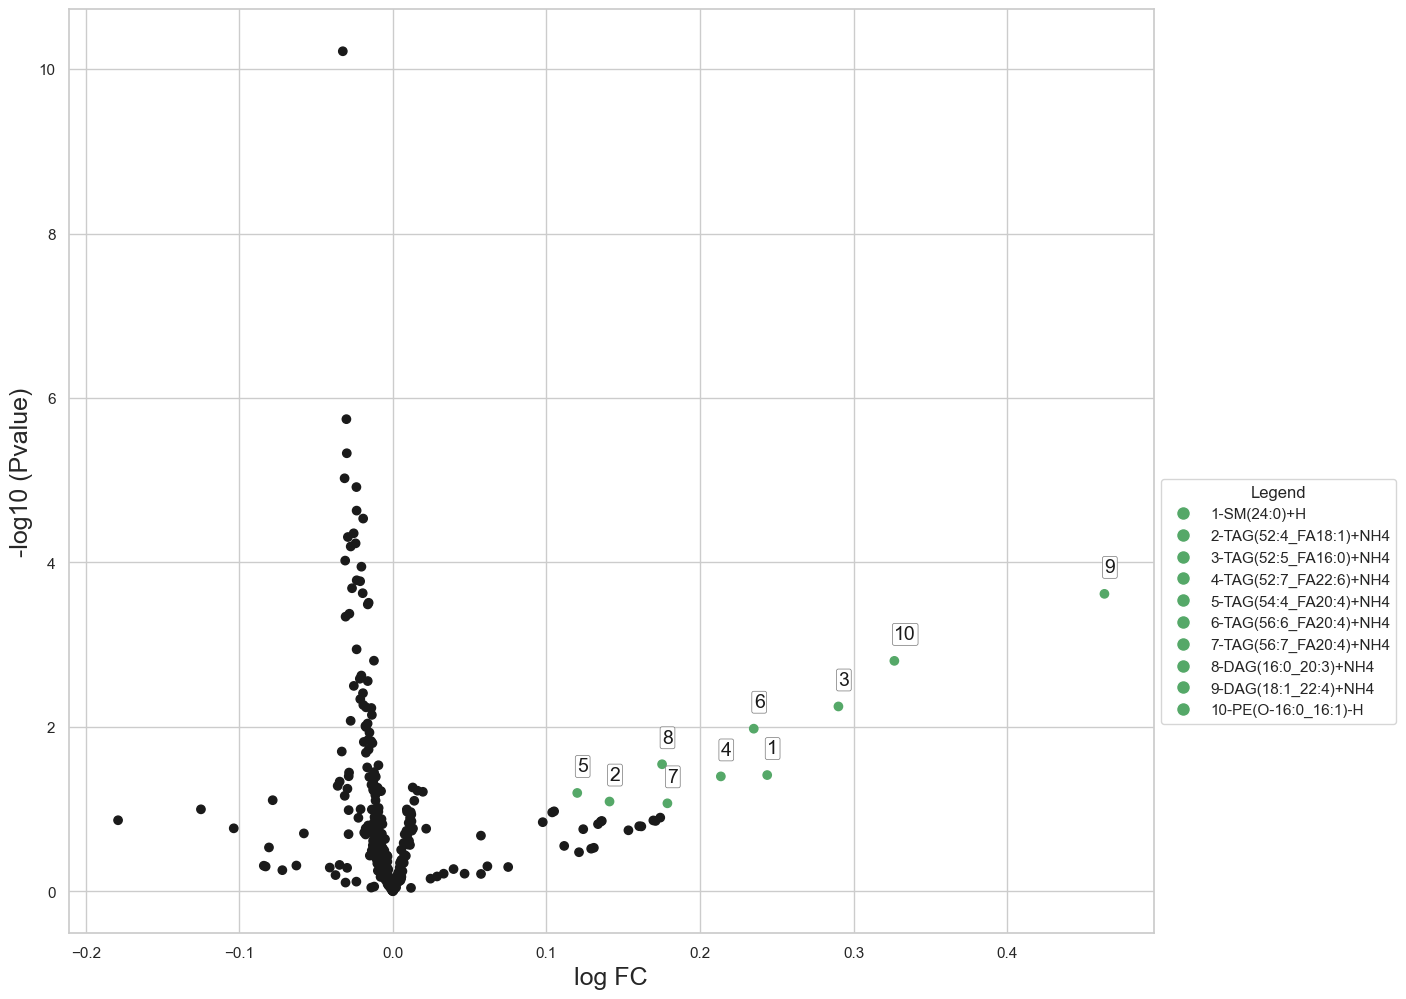

In [172]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-tissuetype-fc_01_pv_1-no-date.png")

## Analysis 30 vs 60

In [173]:
factor = 'PND'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','pnd_treatment.csv'))

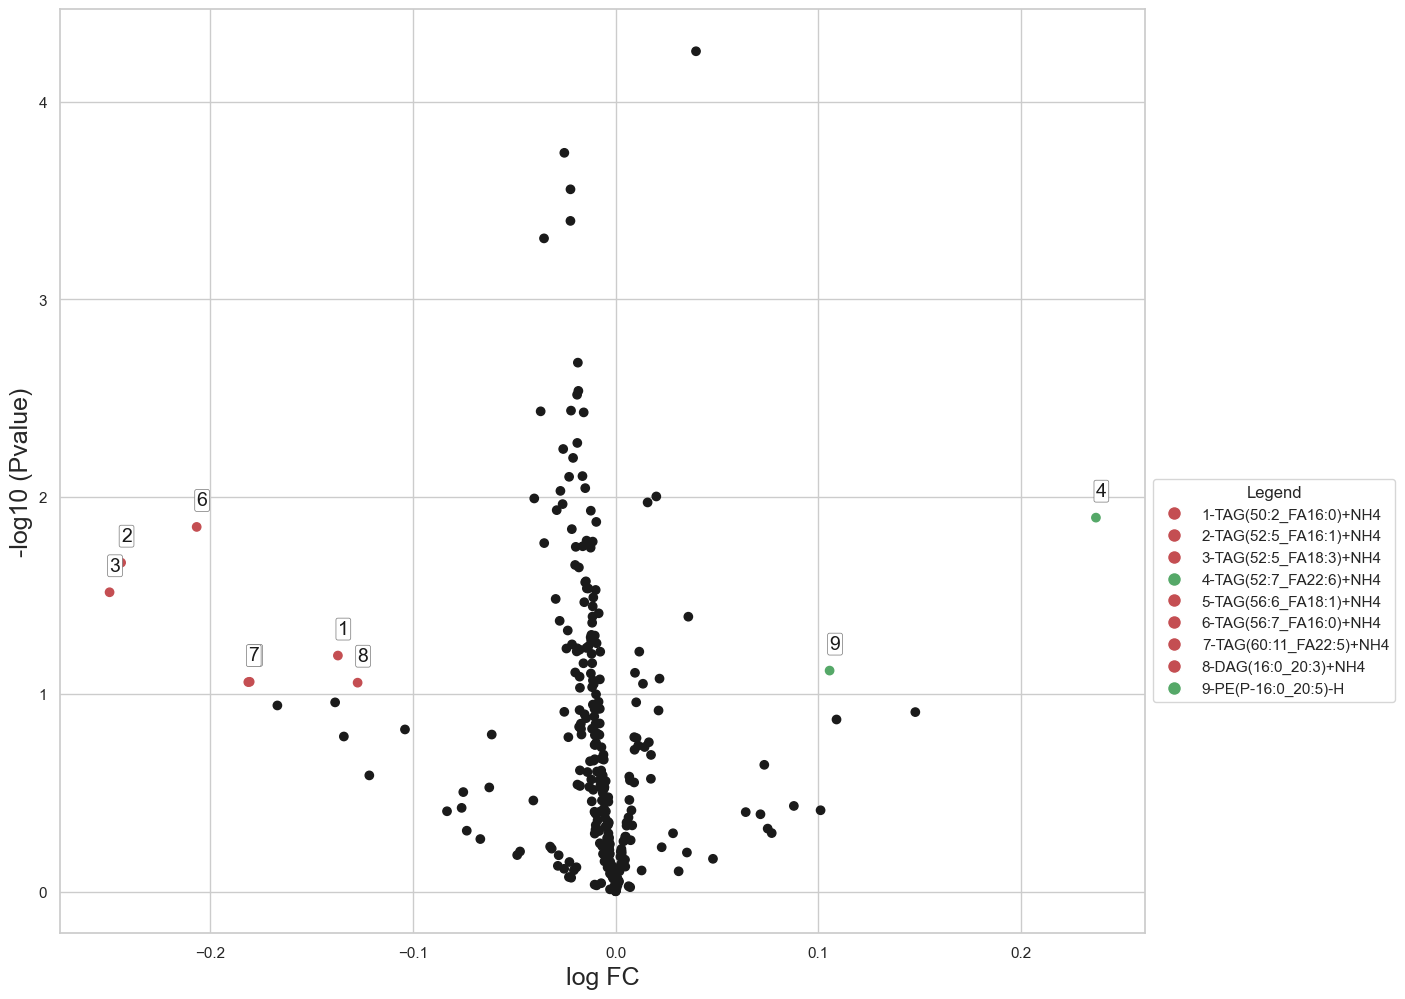

In [174]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-PND-fc_01_pv_1-no-date.png")

## Analysis male vs female

In [175]:
factor = 'Sex'
results_all = []
for l in lipids_list:
    data_lipid = data[data['IndividualLipidSpecies'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['log_scaled_area'].values
            b = data_lipid[data_lipid[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','sex_treatment.csv'))

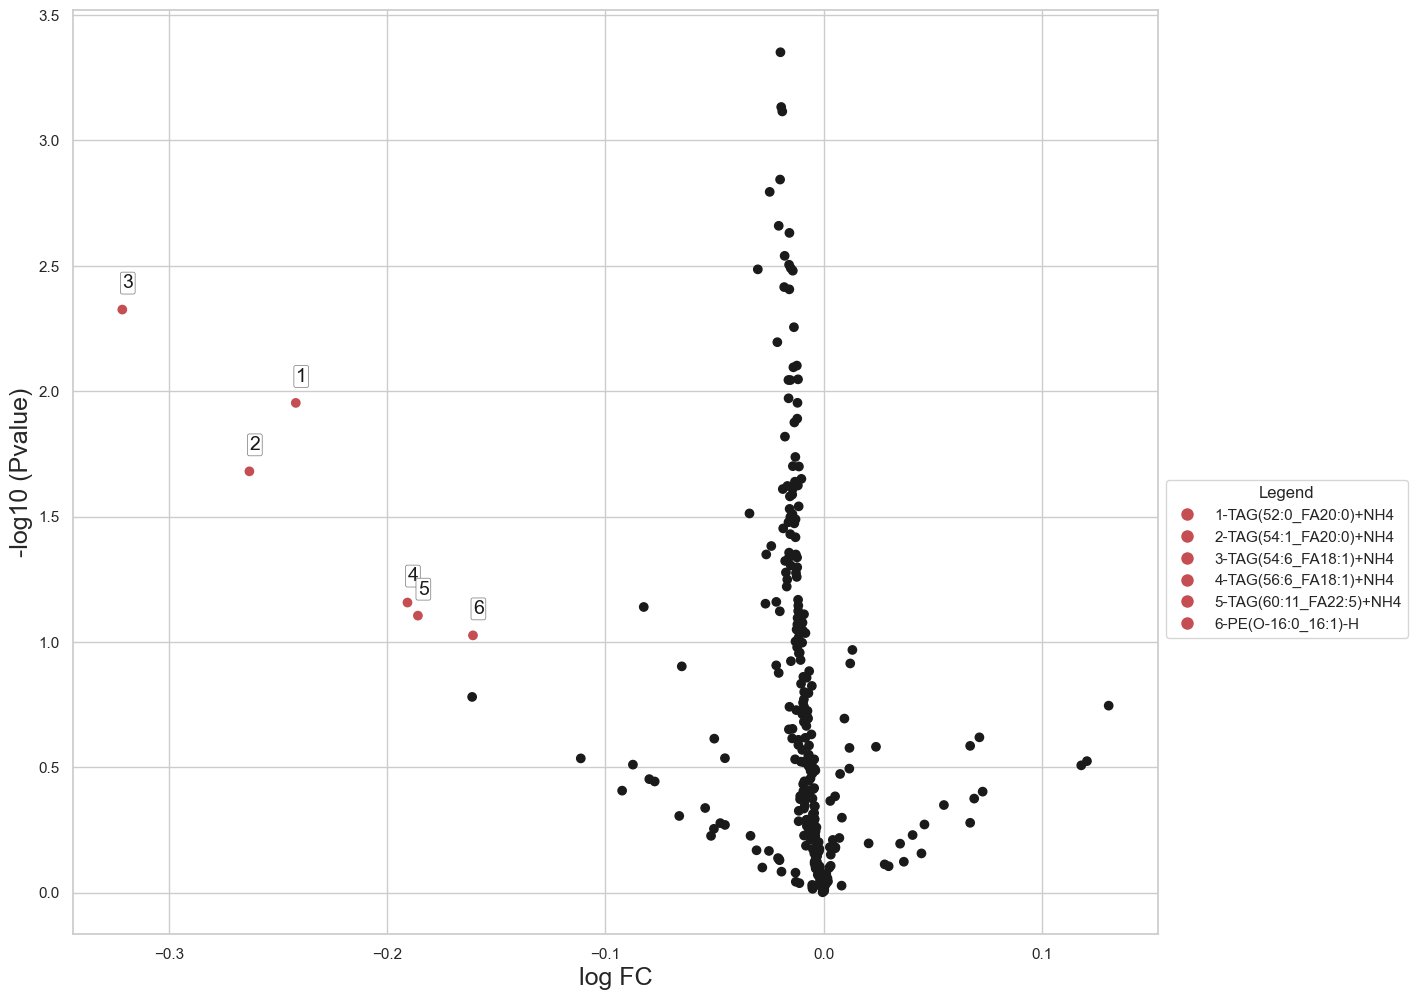

In [176]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-gender-fc_01_pv_1-no-date.png")